## Prepare

In [ ]:
!pip install tensorflow-gpu 
# !pip install tensorflow
!pip install tensorflow_hub matplotlib tokenizers
!pip install tensorflow_text
!pip install bert-for-tf2
!pip install transformers
!pip install cookiecutter

     |████████████████████████████████| 320.4MB 54kB/s 
     |████████████████████████████████| 2.9MB 5.5MB/s 
     |████████████████████████████████| 2.6MB 4.2MB/s 
     |████████████████████████████████| 51kB 3.6MB/s 
  Created wheel for bert-for-tf2: filename=bert_for_tf2-0.14.7-cp36-none-any.whl size=30537 sha256=dfa85e57dc8ba1d5119f4b0bf24aee9186270a90aa364b49f58857e1cc95fddd
  Stored in directory: /root/.cache/pip/wheels/e1/f8/e2/b98f79a6b8cc898d8e4102b83acb8a098df7d27500a2bac912
  Created wheel for py-params: filename=py_params-0.9.7-cp36-none-any.whl size=7302 sha256=8607cc00fdee33a96b5a4770f15f972eae8d384f4b77259353c774d3ef86222a
  Stored in directory: /root/.cache/pip/wheels/67/f5/19/b461849a50aefdf4bab47c4756596e82ee2118b8278e5a1980
  Created wheel for params-flow: filename=params_flow-0.8.2-cp36-none-any.whl size=19475 sha256=523552cb90658eab758305e58b00dedf13d4433b1a6815f75c2b18ad4b02d8de
  Stored in directory: /root/.cache/pip/wheels/08/c8/7f/81c86b9ff2b86e2c477e3914175be

In [ ]:
# Create data folder
!mkdir /content/pre_model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/pretrained_models/chinese_wwm_ext_L-12_H-768_A-12.zip' /content/pre_model/
!unzip -o '/content/pre_model/chinese_wwm_ext_L-12_H-768_A-12.zip' -d '/content/pre_model/chinese_wwm_ext_L-12_H-768_A-12'

Archive:  /content/pre_model/chinese_wwm_ext_L-12_H-768_A-12.zip
  inflating: /content/pre_model/chinese_wwm_ext_L-12_H-768_A-12/bert_config.json  
  inflating: /content/pre_model/chinese_wwm_ext_L-12_H-768_A-12/bert_model.ckpt.data-00000-of-00001  
  inflating: /content/pre_model/chinese_wwm_ext_L-12_H-768_A-12/bert_model.ckpt.index  
  inflating: /content/pre_model/chinese_wwm_ext_L-12_H-768_A-12/bert_model.ckpt.meta  
  inflating: /content/pre_model/chinese_wwm_ext_L-12_H-768_A-12/vocab.txt  


In [ ]:
import os

In [ ]:
wwm_model_dir = '/content/pre_model/chinese_wwm_ext_L-12_H-768_A-12'
wwm_model_ckpt = os.path.join(wwm_model_dir, "bert_model.ckpt")
wwm_model_ckpt_index = os.path.join(wwm_model_dir, "bert_model.ckpt.index")
wwm_model_config = os.path.join(wwm_model_dir, "bert_config.json")

In [ ]:
!wwm_model_dir='/content/pre_model/chinese_wwm_ext_L-12_H-768_A-12' transformers-cli convert --model_type bert \
  --tf_checkpoint $wwm_model_dir/bert_model.ckpt \
  --config $wwm_model_dir/bert_config.json \
  --pytorch_dump_output $wwm_model_dir/pytorch_model.bin


2020-12-14 15:30:04.489848: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Building PyTorch model from configuration: BertConfig {
  "attention_probs_dropout_prob": 0.1,
  "directionality": "bidi",
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "pooler_fc_size": 768,
  "pooler_num_attention_heads": 12,
  "pooler_num_fc_layers": 3,
  "pooler_size_per_head": 128,
  "pooler_type": "first_token_transform",
  "type_vocab_size": 2,
  "vocab_size": 21128
}

Converting TensorFlow checkpoint from /content/pre_model/chinese_wwm_ext_L-12_H-768_A-12/bert_model.ckpt
Loading TF weight bert/embeddings/LayerNorm/beta with shape [768]
Loading TF weight

## Import modules

In [ ]:
import pandas as pd
import numpy as np
import os
import json

os.environ['TFHUB_DOWNLOAD_PROGRESS'] = '1'

from tqdm import tqdm
import tensorflow as tf
import tensorflow_hub as tf_hub
import tensorflow as tf
import tensorflow_text as tf_text
from tokenizers import BertWordPieceTokenizer
from transformers import BertTokenizer, TFBertModel, BertConfig, BertModel, BertForPreTraining, TFBertForPreTraining

import matplotlib.pyplot as plt
%matplotlib inline

## Methods

In [ ]:
def _compose_bert_data_input_by_tokenizer_to_dict(data, batch_size=32, max_seq_length=128):
  
  X_word_ids = []
  X_masks = []
  X_seq = []

  for x in tqdm(data):
    
    input_ids = []
    
    segment_ids = []

    t_encoder = tokenizer.encode(x.get('q1'), x.get('q2'))
    t_encoder.pad(max_seq_length)
    tokens = t_encoder.tokens

    X_word_ids.append(t_encoder.ids)
    X_masks.append(t_encoder.attention_mask)
    X_seq.append(t_encoder.type_ids)

  Y = [
       int(x.get('label')) for x in tqdm(data)
  ]

  X_word_ids = np.array(X_word_ids)
  X_masks = np.array(X_masks)
  X_seq = np.array(X_seq)
  Y = np.array(Y)

  # X_word_ids = tf.ragged.constant(X_word_ids, tf.int32, name="input_word_ids")
  # X_masks = tf.ragged.constant(X_masks, tf.int32, name="attention_mask")
  # X_seq = tf.ragged.constant(X_seq, tf.int32, name="token_type_ids")
  # Y = tf.constant(Y, tf.int32)
  return {
        "input_word_ids": X_word_ids,
        "attention_mask": X_masks,
        "token_type_ids": X_seq,
        "label": Y}

## Data

In [ ]:
!wget https://raw.githubusercontent.com/ccuulinay/texts_semantic_sim/master/data/train.txt
!wget https://raw.githubusercontent.com/ccuulinay/texts_semantic_sim/master/data/test.txt

--2020-12-14 15:30:16--  https://raw.githubusercontent.com/ccuulinay/texts_semantic_sim/master/data/train.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5174256 (4.9M) [text/plain]
Saving to: ‘train.txt’

train.txt           100%[===================>]   4.93M  24.0MB/s    in 0.2s    

2020-12-14 15:30:18 (24.0 MB/s) - ‘train.txt’ saved [5174256/5174256]

--2020-12-14 15:30:18--  https://raw.githubusercontent.com/ccuulinay/texts_semantic_sim/master/data/test.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2553277 (2.4M) [text/plain]

In [ ]:
train_file = "train.txt"
test_file = "test.txt"

In [ ]:
train = pd.read_csv(train_file, sep="\t", header=None, names=["q1", "q2", "label"])
test = pd.read_csv(test_file, sep="\t", header=None, names=["q1", "q2", "label"])

DATA_COLUMNS = ["q1", "q2"]
LABEL_COLUMN = 'label'

In [ ]:
train["label"].isna().sum()

0

In [ ]:
_train_0 = train[train[LABEL_COLUMN] == 0].sample(2500)
_train_1 = train[train[LABEL_COLUMN] == 1].sample(2500)
train = pd.concat([_train_0, _train_1])

_test_0 = test[test[LABEL_COLUMN] == 0].sample(2500)
_test_1 = test[test[LABEL_COLUMN] == 1].sample(2500)
test = pd.concat([_test_0, _test_1])


In [ ]:
tokenizer = BertWordPieceTokenizer("/content/pre_model/chinese_wwm_ext_L-12_H-768_A-12/vocab.txt")
tokenizer.enable_truncation(128)

In [ ]:
data_train = _compose_bert_data_input_by_tokenizer_to_dict(train.to_dict(orient='records'))
data_test = _compose_bert_data_input_by_tokenizer_to_dict(test.to_dict(orient='records'))

100%|██████████| 5000/5000 [00:00<00:00, 1031758.34it/s]


## Build model

In [ ]:
## This is pytorch layer
# bert_config = BertConfig.from_json_file(wwm_model_config)
# bert_layer = BertForPreTraining.from_pretrained(
#     wwm_model_ckpt,
#     # wwm_model_ckpt_index, 
#     from_tf=True, 
#     # from_pt=False,
#     config=bert_config
#     )

In [ ]:
bert_config = BertConfig.from_pretrained(wwm_model_config)
encoder = TFBertModel.from_pretrained(wwm_model_dir, from_pt=True, config=bert_config)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'bert.embeddings.position_ids', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the 

In [ ]:
max_seq_len = 128
BATCH_SIZE = 32
# LEARNING_RATE = 3e-5
LEARNING_RATE = 2e-5
# LEARNING_RATE = 1e-5
# LEARNING_RATE = 0.000015
NUM_TRAIN_EPOCHS = 5

In [ ]:
input_word_tokens = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.string, name="input_tokens")

input_word_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                       name="input_word_ids")
input_mask = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                   name="attention_mask")
segment_ids = tf.keras.layers.Input(shape=(max_seq_len,), dtype=tf.int32,
                                    name="token_type_ids")


seq_ouput = encoder(
    # [input_word_ids, segment_ids]
    input_word_ids, 
    token_type_ids=segment_ids, 
    # attention_mask=input_mask
)[0]
pooled = tf.keras.layers.GlobalAveragePooling1D()(seq_ouput)
flat = tf.keras.layers.Flatten()(seq_ouput)
logits = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)(pooled)



In [ ]:
cls = tf.keras.Model(inputs=[input_word_ids, segment_ids], outputs=logits)

In [ ]:
cls.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
token_type_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
tf_bert_model (TFBertModel)     TFBaseModelOutputWit 102267648   input_word_ids[0][0]             
                                                                 token_type_ids[0][0]             
__________________________________________________________________________________________________
global_average_pooling1d (Globa (None, 768)          0           tf_bert_model[0][0]   

In [ ]:
cls.compile(
    loss='binary_crossentropy', 
    optimizer=tf.optimizers.Adam(lr=LEARNING_RATE), 
    metrics=['accuracy']
)

In [24]:
history = cls.fit(
    [data_train["input_word_ids"], data_train["token_type_ids"]],
    data_train["label"],
    # epochs=5,
    epochs=NUM_TRAIN_EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=([data_test["input_word_ids"], data_test["token_type_ids"]], data_test["label"]),
    verbose=1
    )

Epoch 1/5
157/157 [==============================] - 317s 2s/step - loss: 0.7091 - accuracy: 0.5168 - val_loss: 0.6326 - val_accuracy: 0.6614
Epoch 2/5
157/157 [==============================] - 313s 2s/step - loss: 0.5968 - accuracy: 0.6834 - val_loss: 0.5463 - val_accuracy: 0.7204
Epoch 3/5
157/157 [==============================] - 313s 2s/step - loss: 0.4610 - accuracy: 0.7892 - val_loss: 0.5176 - val_accuracy: 0.7408
Epoch 4/5
157/157 [==============================] - 313s 2s/step - loss: 0.3347 - accuracy: 0.8538 - val_loss: 0.5546 - val_accuracy: 0.7406
Epoch 5/5
157/157 [==============================] - 314s 2s/step - loss: 0.2093 - accuracy: 0.9246 - val_loss: 0.7253 - val_accuracy: 0.7222


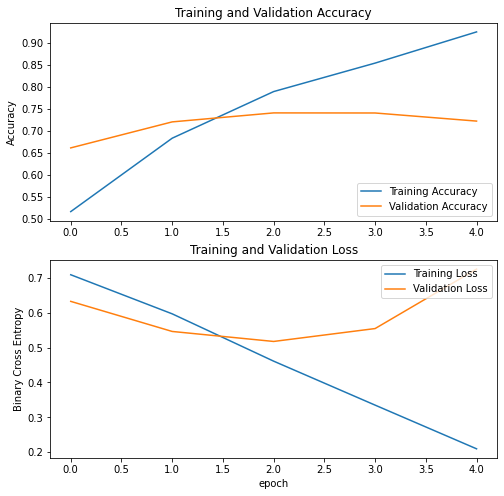

In [28]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Binary Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [29]:
test_prop = cls.predict(([data_test["input_word_ids"], data_test["token_type_ids"]]))
test_pred = np.where(test_prop > 0.5, 1, 0).flatten()

In [32]:
test_labels = data_test["label"].copy()

In [33]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix  
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

In [34]:
cm = confusion_matrix(test_labels, test_pred)  
print(cm)  
print()
print("F1 score", f1_score(test_labels, test_pred))
print('Accuracy', accuracy_score(test_labels, test_pred))
print('ROC AUC SCORE', roc_auc_score(test_labels, test_prop))
print(classification_report(test_labels, test_pred))

[[1867  633]
 [ 756 1744]]

F1 score 0.7151937666598319
Accuracy 0.7222
ROC AUC SCORE 0.8002971200000001
              precision    recall  f1-score   support

           0       0.71      0.75      0.73      2500
           1       0.73      0.70      0.72      2500

    accuracy                           0.72      5000
   macro avg       0.72      0.72      0.72      5000
weighted avg       0.72      0.72      0.72      5000

